In [1]:
import dask.array as da
import warnings

import dask.array as da
from sklearn.pipeline import Pipeline
from dask_ml.model_selection import train_test_split
from dask_ml.model_selection import GridSearchCV
from dask_ml.decomposition import PCA
from dask_ml.preprocessing import PolynomialFeatures
from dask_ml.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np
import pandas
from toolz.curried import groupby, valmap, pipe, pluck, merge_with, merge
from toolz.curried import map as fmap

from pymks.fmks.data.elastic_fe import solve
from pymks.fmks.data.multiphase import generate

from pymks.fmks.plot import plot_microstructures
from pymks.fmks.bases.primitive import PrimitiveTransformer
from pymks.fmks.correlations import TwoPointCorrelation, FlattenTransformer
from dask.distributed import Client, progress
import time
from mpl_toolkits import mplot3d
%matplotlib notebook


In [2]:
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
da.random.seed(10)
np.random.seed(10)

tmp = [
    generate(shape=(300, 101, 101,101), grain_size=x, volume_fraction=(0.5, 0.2,0.3), chunks=(10), percent_variance=0.15)
    for x in [(15, 2,2), (2,2, 15), (7,7, 7), (9, 9,3), (9,9, 9), (2, 2,2)]
]
x_data_gen = da.concatenate(tmp)

In [4]:
x_data_gen

,Array,Chunk
Bytes,14.84 GB,82.42 MB
Shape,"(1800, 101, 101, 101)","(10, 101, 101, 101)"
Count,540 Tasks,180 Chunks
Type,int64,numpy.ndarray


In [5]:
print(x_data_gen.shape)
print(x_data_gen.chunks)


(1800, 101, 101, 101)
((10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10), (101,), (101,), (101,))


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.742225 to fit


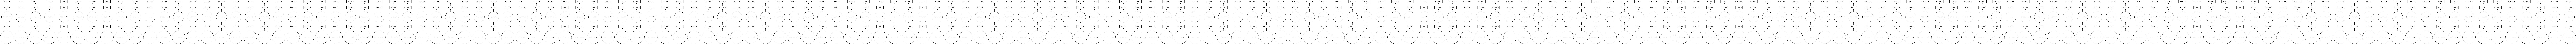

In [6]:
x_data_gen.visualize()

In [7]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41045 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.59 GB


In [8]:
# client = Client( threads_per_worker=2,
#                 n_workers=2, memory_limit='8GB')
# client

In [9]:
bl1 = Pipeline(steps=[
    ("discritize",PrimitiveTransformer(n_state=2, min_=0.0, max_=1.0)),
    ("Correlations",TwoPointCorrelation(periodic_boundary=True, cutoff=15,correlations=[(1,1)])),
    ('flatten', FlattenTransformer()),  
    ('reducer',PCA(n_components=3))])

In [10]:
tic = time.time()
b=bl1.fit(x_data_gen)
toc = time.time()
print(tic-toc)
print(b)

-176.4489781856537
Pipeline(memory=None,
         steps=[('discritize',
                 PrimitiveTransformer(chunks=None, max_=1.0, min_=0.0,
                                      n_state=2)),
                ('Correlations',
                 TwoPointCorrelation(correlations=[(1, 1)], cutoff=15,
                                     periodic_boundary=True)),
                ('flatten', FlattenTransformer()),
                ('reducer',
                 PCA(copy=True, iterated_power=0, n_components=3,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False))],
         verbose=False)


In [11]:
tic = time.time()
b=bl1.transform(x_data_gen).compute()
toc = time.time()
print(tic-toc)
print(b)

-181.8160104751587
[[ 24.81046291  -0.3562984   -0.17860129]
 [-20.49446272  -0.31510179  -0.17756921]
 [  7.86266944  -0.33777485  -0.19317313]
 ...
 [ 23.7459414   -0.40943863   0.03743609]
 [-11.05016541  -0.37865952   0.0416818 ]
 [ -9.14925623  -0.37991167   0.04137156]]


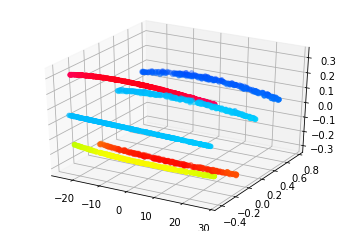

In [12]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# z_line = np.linspace(0, 15, 1000)
# x_line = np.cos(z_line)
# y_line = np.sin(z_line)
# ax.plot3D(x_line, y_line, z_line, 'gray')

z_points = b[:,2]
x_points = b[:,0]
y_points = b[:,1]
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='hsv');

plt.show()